<a href="https://colab.research.google.com/github/adarsh2313/ResNet18-Pytorch/blob/main/resnet_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing and setting defaults

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device('cuda')
torch.cuda.empty_cache()

### ResNet-18 model

In [ ]:
# For the first block alone
class block0(nn.Module):
  def __init__(self):
    super(block0, self).__init__()
    
    self.conv = nn.Conv2d(64,64,kernel_size=3,stride=1,padding='same',bias=False)
    self.bn = nn.BatchNorm2d(64)

  def forward(self, X):
    I = X
    X = self.conv(X)
    X = self.bn(X)
    X = self.bn(self.conv(X))
    X += I
    I = X
    X = self.bn(self.conv(X))
    X = F.relu(X)
    X = self.bn(self.conv(X))
    return X

# For rest of the blocks (general implementation)
class block(nn.Module):
  def __init__(self, nc_in, nc_out):
    super(block,self).__init__()

    self.conv_stride2 = nn.Conv2d(nc_in,nc_out,kernel_size=3,stride=2,padding=1,bias=False)
    self.bn = nn.BatchNorm2d(nc_out)
    self.conv_stride1 = nn.Conv2d(nc_out,nc_out,kernel_size=3,stride=1,padding='same',bias=False)
    self.resize = nn.Conv2d(nc_in,nc_out,kernel_size=1,stride=2,bias=False)

  def forward(self,X):
    I = X
    X = self.conv_stride2(X)
    X = F.relu(self.bn(X))
    X = self.bn(self.conv_stride1(X))
    I = self.bn(self.resize(I))
    X += I
    I = X
    X = F.relu(self.bn(self.conv_stride1(X)))
    X = self.bn(self.conv_stride1(X))
    X += I
    return X

# Incorporating all the blocks
class ResNet18(nn.Module):
  def __init__(self):
    super(ResNet18, self).__init__()

    self.conv1 = nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=False)
    self.bn = nn.BatchNorm2d(64)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer0 = block0()
    self.layer1 = block(64,128)
    self.layer2 = block(128,256)
    self.layer3 = block(256,512)
    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    self.fc1 = nn.Linear(512,1)

  def forward(self,X):
    X = self.conv1(X)
    X = self.bn(X)
    X = F.relu(X)
    X = self.maxpool(X)
    X = self.layer0(X)
    X = self.layer1(X)
    X = self.layer2(X)
    X = self.layer3(X)
    X = self.avgpool(X)
    X = torch.flatten(X,1)
    X = self.fc1(X)
    return X

model = ResNet18().to(device)

### Dataset

0.   Boots
1.   Flip-flops
2.   Loafers
3.   Sandals
4.   Sneakers

In [ ]:
trans = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

train = ImageFolder('/content/drive/MyDrive/projects/shoeDataset/training',transform=trans)
test = ImageFolder('/content/drive/MyDrive/projects/shoeDataset/validation',transform=trans)

train_dl = DataLoader(train,batch_size=16,shuffle=True)
test_dl = DataLoader(test,batch_size=16,shuffle=True)

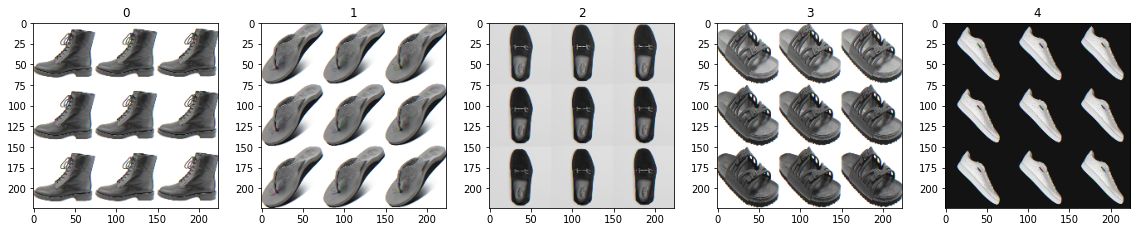

In [ ]:
grid = plt.figure(figsize=(32,32))
grid.add_subplot(8,8,1)
plt.imshow(train[100][0].view(224,224,3))
plt.title(train[100][1])
grid.add_subplot(8,8,2)
plt.imshow(train[400][0].view(224,224,3))
plt.title(train[400][1])
grid.add_subplot(8,8,3)
plt.imshow(train[600][0].view(224,224,3))
plt.title(train[600][1])
grid.add_subplot(8,8,4)
plt.imshow(train[950][0].view(224,224,3))
plt.title(train[950][1])
grid.add_subplot(8,8,5)
plt.imshow(train[1249][0].view(224,224,3))
plt.title(train[1249][1])
plt.show()

### Training

In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 0.003)
lossfn = nn.MSELoss()
epochs = 150
train_l,train_acc,val_l,val_acc = [],[],[],[]

for epoch in range(epochs):
  
  epoch_loss,epoch_acc = 0,0
  model.train()

  for input,label in train_dl:
    input = input.cuda()
    label = label.cuda().type(torch.float)
    label = torch.reshape(label,(-1,1))
    pred = model(input)
    loss = lossfn(pred,label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()/len(train_dl)
    train_l.append(epoch_loss)
  
  if epoch%10 == 0:
    print('\nEpoch',epoch)
    print('Loss = ',epoch_loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Epoch 0
Loss =  3.5521754705453237

Epoch 5
Loss =  0.6934847858133196

Epoch 10
Loss =  0.17844043087355702

Epoch 15
Loss =  0.16403631565361468

Epoch 20
Loss =  0.12570087144835082

Epoch 25
Loss =  0.1619499112550122

Epoch 30
Loss =  0.14470914796089077

Epoch 35
Loss =  0.12019443546740131

Epoch 40
Loss =  0.12958164293837696

Epoch 45
Loss =  0.14769168166573385


### Validation

In [ ]:
model.eval()
with torch.no_grad():
  crct, total = 0,0
  for input,label in test_dl:
    input = input.cuda()
    label = label.cuda().type(torch.float)
    label = torch.reshape(label,(-1,1))
    pred = model(input)
    t_loss = lossfn(pred,label)

    crct += (torch.round(pred)==label).sum().item()
    total += label.size()[0]

  print('Accuracy on the test set = {:.2f}%'.format(100*crct/total))

Accuracy on the test set = 23.92%
